# A Practical Guide to Building a Seq2Seq Transformer from scratch with PyTorch

## Introduction

This jupyter notebook details how to build a **sequence-to-sequence** (Seq2Seq) model using **PyTorch**, focusing on the **Transformer** architecture. Our goal is to develop a transpiler that translates and transpiles PL/I code into Kotlin. Throughout the notebook, we’ll cover everything from setting up the necessary libraries to training the model and evaluating its performance

## Libraries and setup

We start by installing the required libraries:

In [ ]:
!pip install torch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2
!pip install torchtext==0.8.1
!pip install antlr4-python3-runtime==4.9.2

We then import all the necessary libraries. **json** will be used to import our data, **antlr4** provides the backbone for our transpiler, enabling us to parse PL/I code and manipulate its structure with ease, **torch** PyTorch empowers us to build and train neural networks seamlessly, **torchtext** complements PyTorch by providing utilities for text processing and dataset handling, **jinja2** simplifies code generation with its template engine ensuring a smooth transition between languages and to finish **matplotlib** will come in handy during training for visualising our progress  

In [2]:
import json

from antlr4 import *
from pli.PLILexer import PLILexer
from pli.PLIParser import PLIParser
from pli.PLIVisitor import PLIVisitor

import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data import Field, TabularDataset, BucketIterator

from jinja2 import Template

import matplotlib.pyplot as plt

## The Transformer Model

The Transformer class encapsulates a custom implementation of the Transformer model, a powerful architecture for **sequence-to-sequence** tasks. It comprises various components, including **embedding layers** for source and target sequences, **positional embeddings** to capture sequence order, and a multi-layer Transformer module. The model utilizes **dropout** for regularization and employs **masks** to handle padding and prevent information leakage during training. With these components, the Transformer class can efficiently process source and target sequences, facilitating tasks like language translation or code generation

In [3]:
class Transformer(nn.Module):

    # Initialises the Transformer model
    def __init__(
            self,
            embedding_size,
            src_vocab_size,
            trg_vocab_size,
            src_pad_idx,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
            max_len,
            device,
    ):
        super(Transformer, self).__init__()
        self.src_word_embedding = nn.Embedding(src_vocab_size, embedding_size)
        self.src_position_embedding = nn.Embedding(max_len, embedding_size)
        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len, embedding_size)

        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
        )
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx

    # Generates a mask for the source sequence to handle padding
    def make_src_mask(self, src):
        src_mask = src.transpose(0, 1) == self.src_pad_idx

        # (N, src_len)
        return src_mask.to(self.device)

    # Forward pass of the Transformer model
    def forward(self, src, trg):
        src_seq_length, N = src.shape
        trg_seq_length, N = trg.shape

        src_positions = (
            torch.arange(0, src_seq_length)
                .unsqueeze(1)
                .expand(src_seq_length, N)
                .to(self.device)
        )

        trg_positions = (
            torch.arange(0, trg_seq_length)
                .unsqueeze(1)
                .expand(trg_seq_length, N)
                .to(self.device)
        )

        embed_src = self.dropout(
            (self.src_word_embedding(src) + self.src_position_embedding(src_positions))
        )
        embed_trg = self.dropout(
            (self.trg_word_embedding(trg) + self.trg_position_embedding(trg_positions))
        )

        src_padding_mask = self.make_src_mask(src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(
            self.device
        )

        out = self.transformer(
            embed_src,
            embed_trg,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask,
        )
        out = self.fc_out(out)
        return out

## Data preparation and tokenization

For our model to understand and generate text, we need to tokenize our input data. We also set up our datasets to allow us to manage training and testing data efficiently

### Tokenize

We define a simple **tokenizer** that splits a string into tokens based on whitespace, it then creates two **Field** objects with some specifications and finally we create a dictionary that maps field names to tuples to be used later to specify how to load and process the data 

In [5]:
import torchtext.data as data

tokenizer = lambda x: x.split()

pli = data.Field(sequential=True, use_vocab=True, tokenize=tokenizer, lower=True, init_token="<sos>", eos_token="<eos>")
ktl = data.Field(sequential=True, use_vocab=True, tokenize=tokenizer, lower=True, init_token="<sos>", eos_token="<eos>")

fields = {'pli': ('p', pli), 'ktl': ('k', ktl)}

### Splits

We're using the TabularDataset module from the torchtext.data package to create separate datasets for **training** and **testing**. The data is loaded from JSON files located in the 'data' directory. We specify the format of the data as JSON and define the fields to be extracted from the JSON files using the fields parameter

In [7]:
train, test = data.TabularDataset.splits(
    path='data',
    train='train.json',
    test='test.json',
    format='json',
    fields=fields,
)

### Vocab

Building a vocabulary involves creating a dictionary that maps each unique word in the dataset to a unique index. This process is crucial for natural language processing tasks as it allows machine learning models to represent words as numerical values, which they can process and understand. In this case, we're building vocabularies for the PL/I (pli) and Kotlin (ktl) datasets, ensuring that the model has a predefined set of words it can understand and process during training and inference


In [8]:
pli.build_vocab(train, max_size=10000, min_freq=1)
ktl.build_vocab(train, max_size=10000, min_freq=1)

## Translate and transpile

### Translate

Here we define a **translate_sequence** function. It tokenizes the input sentence, adds < sos > and < eos > tokens at the beginning and end respectively, converts the tokens to indices using the vocabulary of the pli field, converts the indices to a PyTorch tensor, and iteratively predicts the next token in the translated sequence using the trained model until either the < eos > token is predicted or the maximum length is reached. Finally, it converts the predicted indices back to tokens using the vocabulary of the Kotlin field and returns the translated sentence, removing the start token < sos > as it is only used for signaling the model to start generation and is not part of the actual translated text

In [9]:
def translate_sequence(sentence, pli, ktl, device, max_length=50):
    if type(sentence) == str:
        tokens = [token.lower() for token in sentence.split()]
    else:
        tokens = [token.lower() for token in sentence]
    # Add <SOS> and <EOS> in beginning and end respectively

    tokens.insert(0, pli.init_token)
    tokens.append(pli.eos_token)

    # Iterate  each languae token and convert to an index
    text_to_indices = [pli.vocab.stoi[token] for token in tokens]

    # Convert to Tensor
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    outputs = [ktl.vocab.stoi["<sos>"]]
    for i in range(max_length):
        trg_tensor = torch.LongTensor(outputs).unsqueeze(1).to(device)

        with torch.no_grad():
            output = model(sentence_tensor, trg_tensor)

        best_guess = output.argmax(2)[-1, :].item()
        outputs.append(best_guess)

        if best_guess == ktl.vocab.stoi["<eos>"]:
            break

    translated_sentence = [ktl.vocab.itos[idx] for idx in outputs]
    # remove start token
    return translated_sentence[1:]

### Transpile

We also define a **transpile_sequence** function. It retrieves the code tokens and context data from the input dictionary. Then, it initializes an empty list to store the transpiled code with proper indentation. The function then iterates through the tokens, adjusting the indentation level based on curly braces {} encountered in the code. It ignores the <eos> token. And after iterating through all the tokens, the function joins the transpiled code with proper spacing and renders it using the contextual data. Finally, it returns the transpiled code and the updated indentation level

In [10]:
def transpile_sequence(translated, level):
    tokens = translated["code"]
    data = translated["context"]
    lint = []

    for t in tokens:
        spacer = "".rjust(level * 4)
        if t == "{":
            level += 1
        elif t == "}" and level > 0:
            level -= 1
            spacer = "".rjust(level * 4)

        if t != "<eos>":
            lint.append(spacer + t)

    code = " ".join(lint)
    t = Template(code)

    return t.render(data), level

## Specifics

Before defining the final parameters and training our model we have a few useful functions to define

This **remove_eos** function removes all < eos > tokens and then concatenate the remaining tokens into a single string

In [11]:
def remove_eos(witheos):
    noeos = []
    for w in witheos:
        if w != '<eos>':
            noeos.append(w)
    return " ".join(noeos)

The following functions, **save_checkpoint** and **load_checkpoint**, are essential for saving and loading the state of our model during training or inference

In [12]:
def save_checkpoint(state, filename="checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

## Training

### Hyperparameters

We start by defining some **model hyperparameters** that help define how our model processes and transforms our input data. We also define some **training hyperparameters** that regulate the training process of our model

In [18]:
# ready to define everything we need for training our Seq2Seq model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

load_model = True
save_model = True

# Model hyperparameters
src_vocab_size = len(pli.vocab)
trg_vocab_size = len(ktl.vocab)
embedding_size = 512
num_heads = 8
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.10
max_len = 100
forward_expansion = 4
src_pad_idx = ktl.vocab.stoi["<pad>"]

global level
# Training hyperparameters
num_epochs = 300
learning_rate = 3e-4
batch_size = 32
training_losses = []

### Model Initialization and Training Setup

We then **initialize** the **model**, **optimizer**, **scheduler**, and **criterion** for training a Transformer model. we also create **iterators** for the training and test datasets that facillitate efficient data management, improve computational efficiency, and enhance the overall training process's effectiveness

In [15]:
train_iterator, test_iterator = BucketIterator.splits(
    (train, test),
    batch_size=batch_size,
    sort_within_batch=True,
    sort_key=lambda x: len(x.p),
    device=device,
)
model = Transformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=10, verbose=True
)

pad_idx = ktl.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

### Training loop

Finaly we define our custom training loop. Within the training loop, batches of data are fetched using the **training_iterator**. Input and target sequences are transferred to the appropriate device (CPU or GPU), and the model is then trained using **forward** and **backward** passes. **Gradient clipping** is applied to prevent exploding gradients, and the **optimizer** is used to update the model parameters based on the computed gradients. After training, we evaluate the model's performance on example pli sequences, translating them to Kotlin using the trained model. Finally we utilise matplotlib to visualize the training loss over iterations and optionally save the trained model checkpoint for future use

[Epoch 0 / 300]
Translated example sentence:
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> () () <pad> <pad> <pad> <pad>
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Last 5 training losses: []


/usr/local/lib/python3.9/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


[Epoch 50 / 300]
Translated example sentence:
fun main (args: Array<String>)
{
}
Last 5 training losses: [0.11536741256713867, 0.13401655852794647, 0.09288042783737183, 0.0880018100142479, 0.0810730904340744]
[Epoch 100 / 300]
Translated example sentence:
fun main (args: Array<String>)
{
}
Last 5 training losses: [0.002143696416169405, 0.0021836746018379927, 0.002142140408977866, 0.0020195324905216694, 0.0023125687148422003]
Epoch   125: reducing learning rate of group 0 to 3.0000e-05.
Epoch   145: reducing learning rate of group 0 to 3.0000e-06.
[Epoch 150 / 300]
Translated example sentence:
fun main (args: Array<String>)
{
}
Last 5 training losses: [0.0009272661409340799, 0.0009802684653550386, 0.0009581581107340753, 0.0009119620081037283, 0.0009031783556565642]
Epoch   156: reducing learning rate of group 0 to 3.0000e-07.
Epoch   167: reducing learning rate of group 0 to 3.0000e-08.
Epoch   178: reducing learning rate of group 0 to 3.0000e-09.
[Epoch 200 / 300]
Translated example se

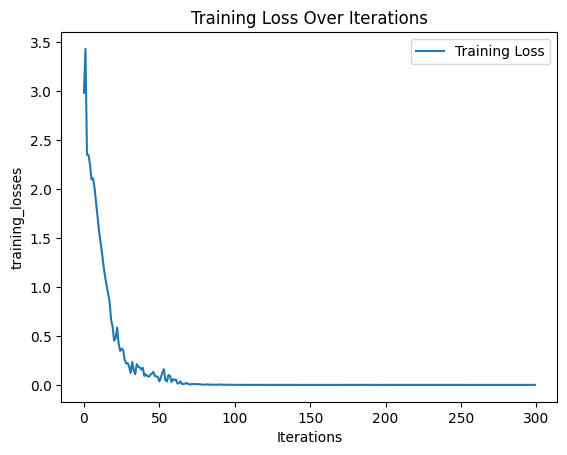

=> Saving checkpoint


In [16]:
if __name__ == '__main__':
    for epoch in range(num_epochs):
        model.eval()
        # little bit of output to check the progress
        if epoch % 50 == 0:
            print(f"[Epoch {epoch} / {num_epochs}]")
            # Iterate over the dataset and extract PLI sequences
            sentences = [
                    {'pli': ['PROCEDURE', 'MAIN', '{{type0}}', '{{type1}}'],
                     'context': {'type0': 'Array', 'type1': 'String'}},
                    {'pli': ['DO'], 'context': {}},
                    {'pli': ['END'], 'context': {}}
                ]
            print(f"Translated example sentence:")
            level = 0
            for s in sentences:
                translated = translate_sequence(
                    s['pli'], pli, ktl, device, max_length=50
                )
                transpiled, level = transpile_sequence({
                    'code': translated,
                    'context': s['context']
                }, level)
                print(f"{transpiled}")
            last_5_losses = training_losses[-5:]
            print("Last 5 training losses:", last_5_losses)
        model.train()
        losses = []
        for batch_idx, batch in enumerate(train_iterator):
            # Get input and targets and get to cuda
            inp_data = batch.p.to(device)
            target = batch.k.to(device)
            # Forward
            output = model(inp_data, target[:-1, :])
            output = output.reshape(-1, output.shape[2])
            target = target[1:].reshape(-1)
            optimizer.zero_grad()
            loss = criterion(output, target)
            losses.append(loss.item())
            # Back prop
            loss.backward()
            # Clip to avoid exploding gradient issues, makes sure grads are
            # within a healthy range
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            # Gradient descent step
            optimizer.step()

            training_losses.append(loss.item())
        mean_loss = sum(losses) / len(losses)
        scheduler.step(mean_loss)
     # Print the final epoch
    print(f"[Epoch {num_epochs} / {num_epochs}]")
    # Iterate over the dataset and extract PLI sequences
    for s in sentences:
        translated = translate_sequence(
            s['pli'], pli, ktl, device, max_length=50
        )
        transpiled, level = transpile_sequence({
            'code': translated,
            'context': s['context']
        }, level)
        print(f"{transpiled}")
        # Translate and transpile here if needed
    last_5_losses = training_losses[-5:]
    print("Last 5 training losses:", last_5_losses)

    plt.plot(training_losses, label='Training Loss')
    plt.xlabel('Iterations')
    plt.ylabel('training_losses')
    plt.title('Training Loss Over Iterations')
    plt.legend()
    plt.show()
if save_model:
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

## Running the Transpiler

And as little bonus we can show you an example of how our transpiller works. We define a **run_model** function where we're processing a PL1 file, which contains original PL1 code. We then load our pre-trained model and its optimizer using the checkpoint file. We set up a lexer and parser for the PL1 code using ANTLR4. We generate a dataset from the parsed code using a visitor pattern, which iterates through the AST (Abstract Syntax Tree) generated by the parser. For each statement in the PL1 code, we translate it into Kotlin using our sequence-to-sequence model and transpile it into Kotlin code. The transpiled Kotlin code is accumulated and printed as the output. This function essentially automates the process of translating our PL1 code to Kotlin

In [17]:
def run_model(filename):

    with open(filename, 'r') as file:
        original_code = file.read()
    print("PL1:")
    print(original_code)
    print()

    load_checkpoint(torch.load("checkpoint.pth.tar"), model, optimizer)
    # Lexer setup
    input_stream = FileStream(filename)
    lexer = PLILexer(input_stream)
    stream = CommonTokenStream(lexer)

    # Parser setup
    parser = PLIParser(stream)
    tree = parser.program()

    # Dataset generation
    visitor = PLIVisitor()
    statements = visitor.visit(tree)

    # Accumulate transpiled sequences
    transpiled_code = ""
    level = 0
    for s in statements:
        translated = translate_sequence(
            s["pli"], pli, ktl, device, max_length=50
        )
        transpiled, level = transpile_sequence({
            'code': translated,
            'context': s['context']
        }, level)
        transpiled_code += transpiled+ "\n"

    # Print the entire block of transpiled code
    print("KTL:")
    print("\n" + transpiled_code)

# Example usage:
filename = "FIB.PLI"  # Replace with the actual filename
run_model(filename)

PL1:

 Factorial: proc options (main);
    dcl (n,result) fixed bin(31);
    n  = 5;
    result = Compute_factorial(n);

 end Factorial;
  /***********************************************/
  /* Subroutine                                  */
  /***********************************************/
  Compute_factorial: proc (n)  returns (fixed bin(31));
     dcl n fixed bin(15);
      if n <= 1 then
        return(1);

     return( n*Compute_factorial(n-1) );

  end Compute_factorial;


=> Loading checkpoint
KTL:

fun main (args: Array<String>)
{
    var     n : Int
    var     result : Int
    n = 5
    result = compute_factorial(n)
}
fun compute_factorial(n : Int) : Int
{
    if(n<=1)
    {
        return 1
    }
    return n*compute_factorial(n-1)
}



# Conclusion

And there you have it ! This notebook provides a comprehensive look at building and training a Seq2Seq Transformer model in PyTorch, from scratch, for in this case the specific task of transpiling PL/I code to Kotlin. The model not only demonstrates the capabilities of neural networks in handling language translation tasks but also highlights the flexibility of the Transformer architecture in processing sequence data.

For those interested in further exploring machine translation models, another article is available where I utilize the Hugging Face API to achieve similar tasks. This API simplifies many of the steps covered here and provides powerful tools to be able to deploy machine translation models in production environments.